## Imports 

In [24]:
# Needs iqm-benchmarks from the github repo to access all the mGST functions: https://github.com/iqm-finland/iqm-benchmarks
from mGST.low_level_jit import dK, objf, ddM, dK_dMdM
from mGST.optimization import tangent_proj
from mGST import additional_fns, algorithm, compatibility
from iqm.benchmarks.compressive_gst.compressive_gst import GSTConfiguration, CompressiveGST
from iqm.benchmarks.compressive_gst.gst_analysis import dataset_counts_to_mgst_format

from qiskit.circuit.library import CZGate, RGate
from iqm.qiskit_iqm import IQMCircuit as QuantumCircuit

from mGST.qiskit_interface import qiskit_gate_to_operator
from time import time

from rustworkx.visualization import mpl_draw
from rustworkx import spring_layout

import numpy as np

from iqm.qiskit_iqm.fake_backends.fake_apollo import IQMFakeApollo
backend = IQMFakeApollo()

## Running the circuits on a simulator

In [3]:
# Q2_GST = GSTConfiguration(
#     qubit_layouts=[[0, 1]],
#     gate_set="2QXYCZ",
#     num_circuits=800,
#     shots=1000,
#     rank=4,
# )

# Example configurations for 1 and 3 qubits:
# Q1_GST = GSTConfiguration(
#     qubit_layouts=[[0]],
#     gate_set="1QXYI",
#     num_circuits=100,
#     shots=1000,
#     rank=4,
# )

# Q3_GST = GSTConfiguration(
#     qubit_layouts=[[0,1,3]],
#     gate_set="3QXYCZ",
#     num_circuits=1000,
#     shots=1000,
#     rank=1,
# )

### 4 qubit gate set

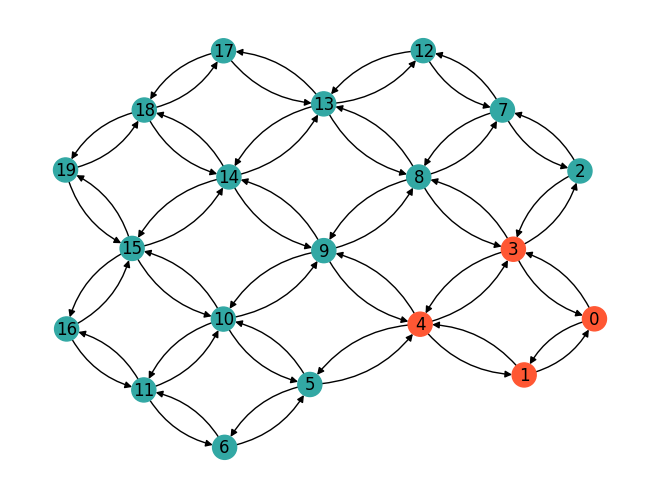

In [26]:
cz_cz = QuantumCircuit(4)
cz_cz.append(CZGate(), [0,1])
cz_cz.append(CZGate(), [2,3])

gate_list = [
    RGate(0.5 * np.pi, 0),
    RGate(0.5 * np.pi, 0),
    RGate(0.5 * np.pi, 0),
    RGate(0.5 * np.pi, 0),
    RGate(0.5 * np.pi, np.pi / 2),
    RGate(0.5 * np.pi, np.pi / 2),
    RGate(0.5 * np.pi, np.pi / 2),
    RGate(0.5 * np.pi, np.pi / 2),
    cz_cz,
]
gates = [QuantumCircuit(4, 0) for _ in range(len(gate_list))]
gate_qubits = [[0], [1], [2], [3], [0], [1], [2], [3], [0, 1, 2, 3]]
for i, gate in enumerate(gate_list):
    if isinstance(gate, QuantumCircuit):
        gates[i].compose(gate, gate_qubits[i], inplace = True)
    else:
        gates[i].append(gate, gate_qubits[i])
gate_labels = ["Rx(pi/2)", "Rx(pi/2)", "Rx(pi/2)", "Rx(pi/2)", 
               "Ry(pi/2)", "Ry(pi/2)", "Ry(pi/2)", "Ry(pi/2)", 
               "CZ-CZ"]

Q4_GST = GSTConfiguration(
    qubit_layouts=[[0,1,3,4]],
    gate_set=gates,
    gate_labels=gate_labels,
    num_circuits=2000,
    shots=1000,
    rank=1,
)

qubit_layouts = [[0,1,3,4]]
node_colors = ['#32a8a4' for _ in range(len(backend.__dict__['_qb_to_idx']))]
for qb in set([qb for layout in qubit_layouts for qb in layout]):
    node_colors[qb] = "#FF5733"
mpl_draw(backend.coupling_map.graph, arrows=True, with_labels=True, node_color=node_colors,
         pos=spring_layout(backend.coupling_map.graph, num_iter=200))

In [30]:
benchmark = CompressiveGST(backend, Q4_GST)
result = benchmark.run()

2025-01-10 13:17:14,967 - iqm.benchmarks.logging_config - INFO - Now generating 2000 random GST circuits...
2025-01-10 13:17:16,336 - iqm.benchmarks.logging_config - INFO - Will transpile all 2000 circuits according to fixed physical layout
2025-01-10 13:17:16,337 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQMFakeApolloBackend with optimization level 0, sabre routing method all circuits
2025-01-10 13:17:23,203 - iqm.benchmarks.logging_config - INFO - Submitting batch with 2000 circuits corresponding to qubits [0, 1, 3, 4]
2025-01-10 13:17:23,219 - iqm.benchmarks.logging_config - INFO - Now executing the corresponding circuit batch
2025-01-10 13:17:23,264 - iqm.benchmarks.logging_config - INFO - Retrieving all counts


## Renaming the parameters for the convention used in the derivatives

In [32]:
qubit_layout = [0, 1, 3, 4]
dataset = result.dataset
y = dataset_counts_to_mgst_format(dataset, qubit_layout)
J = dataset.attrs["J"]
l = dataset.attrs["seq_len_list"][-1]
d = dataset.attrs["num_gates"]
pdim = dataset.attrs["pdim"]
r = pdim ** 2
n_povm = dataset.attrs["num_povm"]
bsize = dataset.attrs["batch_size"]
meas_samples = dataset.attrs["shots"]

rK = 1 # Setting the Kraus rank

# Setting some additional matrix shape parameters for the first and second derivatives
n = rK * pdim
nt = rK * r

## Initialization

In [34]:
## Preparing an initialization (random gate set or target gate set)

target_init = False

if target_init:
    K_target = qiskit_gate_to_operator(dataset.attrs["gate_set"])
    X_target = np.einsum("ijkl,ijnm -> iknlm", K_target, K_target.conj()).reshape(
        (dataset.attrs["num_gates"], dataset.attrs["pdim"] ** 2, dataset.attrs["pdim"] ** 2)
    )  # tensor of superoperators
    
    rho = (
        np.kron(additional_fns.basis(dataset.attrs["pdim"], 0).T.conj(), additional_fns.basis(dataset.attrs["pdim"], 0))
        .reshape(-1)
        .astype(np.complex128)
    )
    
    # Computational basis measurement:
    E = np.array(
        [
            np.kron(
                additional_fns.basis(dataset.attrs["pdim"], i).T.conj(), additional_fns.basis(dataset.attrs["pdim"], i)
            ).reshape(-1)
            for i in range(dataset.attrs["pdim"])
        ]
    ).astype(np.complex128)
    
    
    K = additional_fns.perturbed_target_init(X_target, dataset.attrs["rank"])
    X = np.einsum("ijkl,ijnm -> iknlm", K, K.conj()).reshape((d, r, r))
else:
    K, X, E, rho = additional_fns.random_gs(d, r, rK, n_povm)

## Gradient

The function dK computes the Wirtinger derivative $\frac{\partial \mathcal L}{\partial K}$.
Here $\mathcal L$ is the cost function "objf".

#### Collecting runtimes for 3 qubits
rK=1:
* dK - 39s, gd - 198.8s
rK=2:
* dK - 34s, gd - 179s
rK=8:
* dK - 32s, gd - 158s

#### Collecting runtimes for 4 qubits
rK=1:
* dK - 5378.2s, gd - ???s

In [35]:
# Euclidean Gradient
t0 = time()
dK_ = dK(X, K, E, rho, J, y, d, r, rK)
t_grad = time()-t0
print(t_grad)

5378.216511249542


In [56]:
fixed_gates = np.array([(f"G%i" % i in []) for i in range(d)])

In [57]:
t0 = time()
algorithm.gd(K, E, rho, y, J, d, r, rK, fixed_gates, ls="COBYLA")
t_gd = time()-t0
print(t_gd)

158.9329059123993


## Hessian

The following code computes the Wirtinger derivatives "Fyconjy" $= \frac{\partial^2 \mathcal L}{\partial K \partial K^*}$ and "Fyy" $= \frac{\partial^2 \mathcal L}{\partial K \partial K}$. \
Here $\mathcal L$ is the cost function "objf".

In [8]:
# Euclidean Hessian (can take a while to compute depending on rK)
# compute individual second derivative terms
dK_, dM10, dM11 = dK_dMdM(X, K, E, rho, J, y, d, r, rK)
dd, dconjd = ddM(X, K, E, rho, J, y, d, r, rK)

# Assemple terms
Fyconjy = dM11.reshape(d, nt, d, nt) + np.einsum("ijklmnop->ikmojlnp", dconjd).reshape((d, nt, d, nt)) # Mixed derivate by K and K.conj()
Fyy = dM10.reshape(d, nt, d, nt) + np.einsum("ijklmnop->ikmojlnp", dd).reshape((d, nt, d, nt)) # Second derivate by K

In [9]:
print(K.shape)
print(Fyy.shape, d, nt)
# The second derivative is ordered with d = "nubmer of gates" and nt = pdim*pdim*rK = "Product of all Kraus tensor dimenstions per gate"
# So for instance the second derivative just by gate 0 - parameters is stored in Fyy[0,:,0,:], while a mixed derivative by gate 0 and gate 1 - parameters is in Fyy[0,:,1,:] and Fyy[1,:,0,:]

(5, 4, 4, 4)
(5, 64, 5, 64) 5 64
